In [1]:
import os
import pandas
import math
import itertools
import numpy
import torch
import matplotlib

def parse_folder(folder_name, suffix):
  filenames = os.listdir(folder_name)
  full_filenames = [os.path.join(folder_name, filename) for filename in filenames if filename.endswith(suffix)]
  print("Found", len(full_filenames), "files.\n")

  max_series_length = 0
  max_num_series = 0

  data_dict = dict()

  for file in full_filenames:
    whole_file = open(file, "r")
    star_id = whole_file.readline().strip()
    while((not (star_id.startswith("\\STAR_ID"))) or (star_id.startswith("\\STAR_ID_DEFINED"))):
      star_id = whole_file.readline().strip()
      if not star_id:
        print("Star ID not found for file", file)
        break
    
    line_contents = star_id.split("=", 1)
    star_name = (line_contents[-1]).strip().replace("\'", "").replace("\"", "")

    time_series = pandas.read_table(file, comment="\\", header=None, delim_whitespace=True, skipinitialspace=True)

    time_series = time_series.loc[(pandas.isna(time_series[0]) != True) & (pandas.isna(time_series[1]) != True)]
    for row_label in time_series.index:
      if(pandas.isna(time_series.at[row_label, 2])):
        time_series.at[row_label, 2] = 0
    
    max_series_length = max(max_series_length, len(time_series))
    series_data = [(time_series[i]).tolist() for i in range(3)]

    if star_name in data_dict:
      (data_dict[star_name]).append(series_data)
    else:
      data_dict[star_name] = [series_data]
    max_num_series = max(max_num_series, len(data_dict[star_name]))

  stars_list = list()
  series_masks = dict()
  batched_series = [list() for batch in range(max_num_series)]

  for star in data_dict:
    stars_list.append(star)
    series_masks[star] = ([False]*len(data_dict[star]))+([True]*(max_num_series-len(data_dict[star])))

    for data_series in data_dict[star]:
      for data_axis in range(3):
        extend_factor = math.ceil(max_series_length/len(data_series[data_axis]))
        data_series[data_axis] = ((data_series[data_axis])*extend_factor)[:max_series_length]
        
    for data_series, into_batch in zip(itertools.cycle(data_dict[star]), range(max_num_series)):
      batched_series[into_batch].append(numpy.asarray(data_series, dtype=numpy.double))

  batches_list = [torch.from_numpy(numpy.asarray(batch, dtype=numpy.double)) for batch in batched_series]
    
  print("Longest data series:", max_series_length)
  print("The most number of data series for one star:", max_num_series)
  return stars_list, series_masks, batches_list

In [2]:
metallicity_table = {"[m/H]":1, "[M/H]":1, "[Fe/H]":2}
def metallicity_parser(input_string):
  return metallicity_table.get(input_string, numpy.nan)

def average_or_nan(series, default=numpy.nan):
  if (pandas.isna(series) != True).any():
    return series.mean()
  else:
    return default

def max_or_nan(series):
  if (pandas.isna(series) != True).any():
    return series.max()
  else:
    return numpy.nan

def find_metallicity_standard(series):
  uses_M_H = (series == 1)
  if uses_M_H.any():
    return 1, uses_M_H
  else:
    uses_Fe_H = (series == 2)
    if uses_Fe_H.any():
      return 2, uses_Fe_H
    else:
      return numpy.nan, uses_Fe_H

def parse_table(file_path, existing_stars, available_series):
  """
  Inputs:
    file_path: String.
    existing_stars: Set. Contains strings.
  Outputs:
    model_x1: 3D PyTorch tensor.
    model_x1_mask: 2D PyTorch tensor.
    model_y: 3D PyTorch tensor.
  """

  triplet_data = {("sy_pm", "sy_pmerr1", "sy_pmerr2"), ("sy_dist", "sy_disterr1", "sy_disterr2")}
  quadruplet_data = {("st_mass", "st_masserr1", "st_masserr2", "st_masslim"), ("st_met", "st_meterr1", "st_meterr2", "st_metlim"),
                     ("st_age", "st_ageerr1", "st_ageerr2", "st_agelim"), ("st_rotp", "st_rotperr1", "st_rotperr2", "st_rotplim")}

  imputable_data_planet_low = ["pl_orbpererr1", "pl_orbsmaxerr1", "pl_masseerr1", "pl_msinieerr1", "pl_orbeccenerr1"]
  imputable_data_planet_high = ["pl_orbpererr2", "pl_orbsmaxerr2", "pl_masseerr2", "pl_msinieerr2", "pl_orbeccenerr2"]
  imputable_data_planet_max = ["cb_flag"]
  planet_data_columns = imputable_data_planet_max + imputable_data_planet_low + imputable_data_planet_high

  imputable_data_star = ["st_masserr1", "st_masserr2", "st_ageerr1", "st_ageerr2", "st_rotperr1", "st_rotperr2",
                         "glat", "glon", "sy_pmerr1", "sy_pmerr2", "sy_disterr1", "sy_disterr2"]
  imputable_data_star_max = ["sy_snum"]
  other_data_star = ["st_metratio", "st_meterr1", "st_meterr2"]
  star_data_columns = imputable_data_star_max + other_data_star + imputable_data_star

  max_imputable_data = imputable_data_planet_max + imputable_data_star_max

  data_table = pandas.read_csv(file_path, converters={"st_metratio":metallicity_parser}, comment='#')
  data_table = data_table.loc[(data_table["hostname"].isin(existing_stars)) & (data_table["rv_flag"] == 1) & (data_table["st_nrvc"] > 0)]

  model_x1_list = list()
  model_x1_paddings = list()
  model_y_list = list()

  max_planets_number = 0
  model_size = max(len(star_data_columns), len(planet_data_columns))
  output_pad = [0]*(len(star_data_columns)-len(planet_data_columns))

  for star in existing_stars:
    planets_table = pandas.DataFrame(columns=data_table.columns)

    exoplanets = set(data_table.loc[data_table["hostname"] == star, "pl_name"])
    for exoplanet in exoplanets:
      use_sources = data_table.loc[data_table["pl_name"] == exoplanet]

      is_non_controversial = (use_sources["pl_controv_flag"] == 0)
      if is_non_controversial.any():
        use_sources = use_sources.loc[is_non_controversial]

      is_confirmed = (use_sources["soltype"] == "Published Confirmed")
      if is_confirmed.any():
        use_sources = use_sources.loc[is_confirmed]

      for row in use_sources.index:
        for (number, uncertainty_up, uncertainty_down) in triplet_data:
          if pandas.isna(use_sources.at[row, number]):
            use_sources.at[row, uncertainty_up] = numpy.nan
            use_sources.at[row, uncertainty_down] = numpy.nan
          else:
            if pandas.isna(use_sources.at[row, uncertainty_up]):
              use_sources.at[row, uncertainty_up] = 0
            use_sources.at[row, uncertainty_up] += use_sources.at[row, number]
            if pandas.isna(use_sources.at[row, uncertainty_down]):
              use_sources.at[row, uncertainty_down] = 0
            use_sources.at[row, uncertainty_down] += use_sources.at[row, number]

        for (number, uncertainty_up, uncertainty_down, limit) in quadruplet_data:
          if pandas.isna(use_sources.at[row, number]):
            use_sources.at[row, uncertainty_up] = numpy.nan
            use_sources.at[row, uncertainty_down] = numpy.nan
          else:
            if pandas.isna(use_sources.at[row, uncertainty_up]):
              use_sources.at[row, uncertainty_up] = 0
            use_sources.at[row, uncertainty_up] += use_sources.at[row, number]
            if(use_sources.at[row, limit] == 1):
              use_sources.at[row, uncertainty_down] = numpy.nan
            else:
              if pandas.isna(use_sources.at[row, uncertainty_down]):
                use_sources.at[row, uncertainty_down] = 0
              use_sources.at[row, uncertainty_down] += use_sources.at[row, number]

      is_default_data = (use_sources["default_flag"] == 1)
      if is_default_data.any():
        planets_table.loc[exoplanet] = use_sources.iloc[is_default_data.argmax()]
      else:
        planets_table.loc[exoplanet] = None

      for column_label in imputable_data_planet_low:
        if pandas.isna(planets_table.at[exoplanet, column_label]):
          planets_table.at[exoplanet, column_label] = average_or_nan(use_sources[column_label], default=0)
      for column_label in imputable_data_planet_high:
        upper_bound = float('inf')
        if(column_label == "pl_orbeccenerr2"):
          upper_bound = 1
        if pandas.isna(planets_table.at[exoplanet, column_label]):
          planets_table.at[exoplanet, column_label] = average_or_nan(use_sources[column_label], default=upper_bound)
      for column_label in imputable_data_star:
        if pandas.isna(planets_table.at[exoplanet, column_label]):
          planets_table.at[exoplanet, column_label] = average_or_nan(use_sources[column_label], default=numpy.nan)

      for column_label in max_imputable_data:
        if pandas.isna(planets_table.at[exoplanet, column_label]):
          planets_table.at[exoplanet, column_label] = max_or_nan(use_sources[column_label])

      if pandas.isna(planets_table.at[exoplanet, "st_metratio"]):
        planets_table.at[exoplanet, "st_metratio"], data_locations = find_metallicity_standard(use_sources["st_metratio"])
        planets_table.at[exoplanet, "st_meterr1"] = average_or_nan(use_sources.loc[data_locations, "st_meterr1"], default=numpy.nan)
        planets_table.at[exoplanet, "st_meterr2"] = average_or_nan(use_sources.loc[data_locations, "st_meterr2"], default=numpy.nan)
      else:
        same_unit = (use_sources["st_metratio"] == planets_table.at[exoplanet, "st_metratio"])
        if pandas.isna(planets_table.at[exoplanet, "st_meterr1"]):
          planets_table.at[exoplanet, "st_meterr1"] = average_or_nan(use_sources.loc[same_unit, "st_meterr1"], default=numpy.nan)
        if pandas.isna(planets_table.at[exoplanet, "st_meterr2"]):
          planets_table.at[exoplanet, "st_meterr2"] = average_or_nan(use_sources.loc[same_unit, "st_meterr2"], default=numpy.nan)

    planets_data = (planets_table[planet_data_columns]).sort_values(planet_data_columns)
    model_y_list.append([numpy.asarray(((planets_data.loc[row_name]).tolist())+output_pad, dtype=numpy.double) for row_name in planets_table.index])
    max_planets_number = max(max_planets_number, len(model_y_list[-1]))

    star_data = dict.fromkeys(star_data_columns, numpy.nan)
    for column_label in imputable_data_star:
      star_data[column_label] = average_or_nan(planets_table[column_label], default=numpy.nan)
    for column_label in imputable_data_star_max:
      star_data[column_label] = max_or_nan(planets_table[column_label])
    star_data["st_metratio"], data_locations = find_metallicity_standard(planets_table["st_metratio"])
    star_data["st_meterr1"] = average_or_nan(planets_table.loc[data_locations, "st_meterr1"], default=numpy.nan)
    star_data["st_meterr2"] = average_or_nan(planets_table.loc[data_locations, "st_meterr2"], default=numpy.nan)

    star_data_list = list()
    padding_list = (available_series[star]).copy()
    for encoding_position, column_name in enumerate(star_data_columns):
      encoding_vector = numpy.zeros(model_size, dtype=numpy.double)
      if not pandas.isna(star_data[column_name]):
        encoding_vector[encoding_position] = star_data[column_name]
        padding_list.append(False)
      else:
        padding_list.append(True)
      star_data_list.append(encoding_vector)
    model_x1_list.append(star_data_list)
    model_x1_paddings.append(padding_list)

  for y_entry in model_y_list:
    for padding in range(max_planets_number-len(y_entry)):
      y_entry.append(numpy.zeros(model_size, dtype=numpy.double))

  model_x1 = torch.from_numpy(numpy.asarray(model_x1_list, dtype=numpy.double))
  model_x1_mask = torch.from_numpy(numpy.asarray(model_x1_paddings, dtype=numpy.bool_))
  model_y = torch.from_numpy(numpy.asarray(model_y_list, dtype=numpy.double))

  print("The most number of planets for one star:", max_planets_number)
  return model_x1, model_x1_mask, model_y

In [3]:
def train_validation_split(main_data, data_mask, series_batch, targets):
  length = (main_data.shape)[0]
  split = int(length*0.8)
  train_batch = [batch[:split] for batch in series_batch]
  validation_batch = [batch[split:] for batch in series_batch]
  return main_data[:split], data_mask[:split], train_batch, targets[:split], main_data[split:], data_mask[split:], validation_batch, targets[split:]

In [4]:
class PlanetDetector(torch.nn.Module):
  def __init__(self):
    super(PlanetDetector, self).__init__()
    self.conv_layers = torch.nn.Sequential(torch.nn.Conv1d(3, 3, 6, stride=2, dtype=torch.double), torch.nn.ReLU(),
                                           torch.nn.Conv1d(3, 2, 6, stride=2, dtype=torch.double), torch.nn.ReLU(),
                                           torch.nn.Conv1d(2, 2, 6, stride=2, dtype=torch.double), torch.nn.ReLU(),
                                           torch.nn.Conv1d(2, 1, 6, stride=2, dtype=torch.double), torch.nn.ReLU(),
                                           torch.nn.Conv1d(1, 1, 6, stride=2, dtype=torch.double), torch.nn.ReLU(),
                                           torch.nn.Linear(17, 16, dtype=torch.double), torch.nn.ReLU())
    self.linear_layers = torch.nn.Sequential(torch.nn.Linear(16, 16, dtype=torch.double),
                                             torch.nn.Linear(16, 16, dtype=torch.double),
                                             torch.nn.Linear(16, 16, dtype=torch.double),
                                             torch.nn.Linear(16, 16, dtype=torch.double),
                                             torch.nn.Linear(16, 16, dtype=torch.double))
    #self.transformer = torch.nn.Transformer(d_model=16, batch_first=True, dtype=torch.double)

  def forward(self, x1, x1_mask, x2s, y):
    after_conv = [self.conv_layers(batch) for batch in x2s]
    full_data = torch.cat((*after_conv, x1), dim=1)
    return self.linear_layers(full_data) #self.transformer(full_data, y, src_key_padding_mask=x1_mask)

model = PlanetDetector()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0, amsgrad=True)

loss_gate = torch.nn.ReLU()
least_square = torch.nn.MSELoss(reduction="mean")
def loss(x1, x1_mask, x2s, y):
  outputs = (model(x1, x1_mask, x2s, y))[:, 0:6, :]
  target = torch.zeros_like(y, dtype=torch.double)

  mask = torch.logical_not(torch.isnan(y))

  exact_loss = least_square(torch.masked_select(outputs[:, :, 0], mask[:, :, 0]), torch.masked_select(y[:, :, 0], mask[:, :, 0]))
  low_loss = least_square(torch.masked_select(loss_gate((y[:, :, 1:5])-(outputs[:, :, 1:5])), mask[:, :, 1:5]), torch.masked_select(target[:, :, 1:5], mask[:, :, 1:5]))
  high_loss = least_square(torch.masked_select(loss_gate((outputs[:, :, 6:10])-(y[:, :, 6:10])), mask[:, :, 6:10]), torch.masked_select(target[:, :, 6:10], mask[:, :, 6:10]))

  return exact_loss+low_loss+high_loss

In [5]:
stars_list, series_masks, batches_list = parse_folder("drive/MyDrive/ECE324/data", ".tbl")
model_x1, model_x1_mask, model_y = parse_table("drive/MyDrive/ECE324/data/PS_2022.03.11_13.14.43.csv", stars_list, series_masks)
X_train, M_train, B_train, Y_train, X_validate, M_validate, B_validate, Y_validate = train_validation_split(model_x1, model_x1_mask, batches_list, model_y)

Found 1071 files.

Longest data series: 678
The most number of data series for one star: 11
The most number of planets for one star: 6


In [6]:
print(len(stars_list))

552


Total epochs: 25


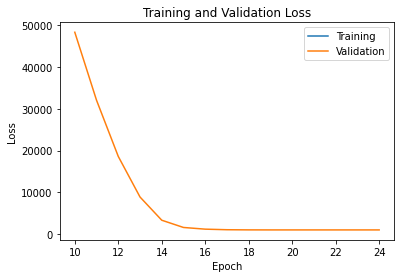

Final validation loss:  1007.5


In [7]:
def auto_stop_train(loss_function, optimizer, X_train, M_train, B_train, Y_train, X_validate, M_validate, B_validate, Y_validate):
  train_loss_record = list()
  validation_loss_record = list()
  best_validation_loss = numpy.inf
  epochs_no_improvement = 0

  for epoch in range(25):
    if not(epochs_no_improvement < 20):
      break
    optimizer.zero_grad(set_to_none=True)
    train_loss = loss_function(X_train, M_train, B_train, Y_train)
    train_loss.backward()
    optimizer.step()

    with torch.no_grad():
      validation_loss = loss_function(X_validate, M_validate, B_validate, Y_validate)
      validation_loss_value = numpy.half(validation_loss.item())
      if((validation_loss_value >= best_validation_loss) or (pandas.isna(validation_loss_value))):
        epochs_no_improvement += 1
      else:
        epochs_no_improvement = 0
      best_validation_loss = min(best_validation_loss, validation_loss_value)

      train_loss_record.append(numpy.half(train_loss.item()))
      validation_loss_record.append(validation_loss_value)

  optimizer.zero_grad(set_to_none=True)
  print("Total epochs:", len(train_loss_record))
  return train_loss_record, validation_loss_record

def loss_plot(train_loss, validation_loss, title_text="Training and Validation Loss", label_x="Epoch"):
  matplotlib.pyplot.title(title_text)
  matplotlib.pyplot.plot(train_loss, label="Training")
  matplotlib.pyplot.plot(validation_loss, label="Validation")
  matplotlib.pyplot.xlabel(label_x)
  matplotlib.pyplot.ylabel("Loss")
  matplotlib.pyplot.legend(loc="best")
  matplotlib.pyplot.show()
  print("Final validation loss: ", validation_loss[-1])

train_loss_record_1, validation_loss_record_1 = auto_stop_train(loss, optimizer, X_train, M_train, B_train, Y_train, X_validate, M_validate, B_validate, Y_validate)
loss_plot(train_loss_record_1, validation_loss_record_1)